<a href="https://colab.research.google.com/github/RGROVE1232/NE-snake-prediction/blob/main/snake_species_train_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Install Needed Libraries**
Install **TensorFlow** (open-source machine learning library), **Keras** (high-level neural networks API that runs with TensorFlow), and **numpy** (package for numerical computing) if not already installed. Import 'drive' module to interact with Google Drive inside the Colab environment. Mount your Google Drive to the Colab environment and authenticate to give access so Google Drive is accessible in the notebook.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Manipulation and Visualization
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

# Directory Operations and Random Number Generation
import os
import random

# Deep Learning Framework
import tensorflow as tf
from tensorflow import keras

# Computer Vision
import cv2

# Machine Learning Metrics
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score

# Image Preprocessing and Callbacks
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.callbacks import ReduceLROnPlateau

# Deep Learning Models/Layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, Reshape, MaxPool2D,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#### **Define Callbacks**
Controls the learning process and saves the best model weights in the process. **ReduceLROnPlateau** reduces the learning rate when validation loss does not improve after '4' epochs. **ModelCheckpoint** saves the model's weights if the validation loss improves compared to the previous epoch. **EarlyStopping** stops training when the validation loss doesn't improve after '6' epochs and restores the best weights for the model.



In [ ]:
def train_model(model, train_generator, validation_generator, epochs, name):

  path_cp = name + '_snake_detector_weights.hdf5'

  rlr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.1,
                          patience = 4,
                          verbose = 1,
                          min_delta = 1e-4,
                          min_lr = 1e-4,
                          mode = 'min',
                          cooldown=1)

  ckp = ModelCheckpoint(path_cp,
                        monitor = 'val_loss',
                        verbose = 1,
                        save_best_only = True,
                        mode = 'min')

  es = EarlyStopping(monitor = 'val_loss',
                     min_delta = 1e-4,
                     patience = 6,
                     mode = 'min',
                     restore_best_weights = True,
                     verbose = 1)

  history = model.fit(train_generator,
                      epochs = epochs,
                      validation_data = validation_generator,
                      verbose = 1,
                      callbacks = [rlr,es,ckp])

  return history

#### **Loading and Pre-Processing Images**
Define the image width and height (150x150) and create an **'ImageDataGenerator'** for the training data. In the generator, the code configures several image augmentation techniques (*see code comments*). The other 'ImageDataGenerator' for the validation data has no augmentation technique apply. This is so any validation image is the original copy and the model will perform better to unseen data.

**'flow_from_directory'** method generates batches of '64' augmented image data from the training and validation directory. Within this function, the code configured several parameters (*see code comments*) that reformat the images before training.

In [ ]:
img_width, img_height = 244, 244

train_generator = ImageDataGenerator(rescale = 1./255, # Scale pixel values to [0, 1] range
                                     shear_range = 0.2, # Apply random shear transformations
                                     zoom_range = 0.3, # Applies random zoom-in and zoom-out transformations
                                     width_shift_range = 0.3, # Applies random horizontal shifts
                                     height_shift_range = 0.2, # Applies random vertical shifts
                                     brightness_range = [0.4, 1.5], # Adjusts the brightness randomly
                                     horizontal_flip = True) # Performs random horizontal flips

val_generator = ImageDataGenerator(rescale = 1./255) # No augmentation techniques for validation

train_generator = train_generator.flow_from_directory(
    directory = '/content/drive/MyDrive/snake-dataset/training', # Path to training dataset
    target_size = (img_width, img_height), # Resize images during training
    color_mode = 'rgb', # Color mode of images
    class_mode = 'categorical', # Types of labels used
    batch_size = 16, # Number of images per batch
    subset = 'training') # Keep set to 'training' as the training set

validation_generator = val_generator.flow_from_directory(
    directory='/content/drive/MyDrive/snake-dataset/validation', # Path to validation dataset
    target_size = (img_width, img_height), # Resize images during training
    color_mode = 'rgb', # Color mode of images
    class_mode = 'categorical', # Types of labels used
    batch_size = 16, # Number of images per batch
    shuffle = False) # Set to false to preserve order of images

Found 2196 images belonging to 24 classes.
Found 939 images belonging to 24 classes.


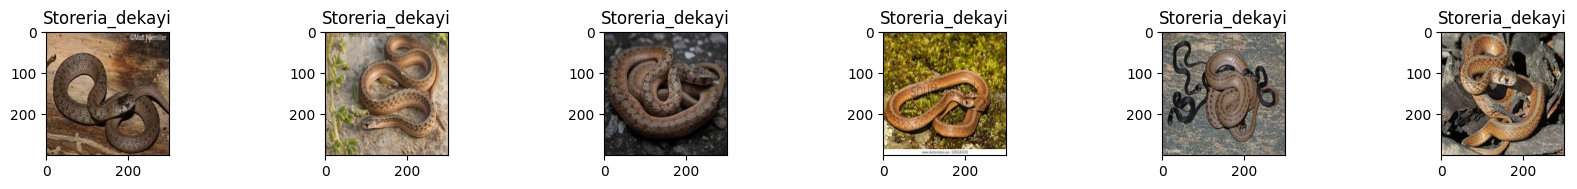

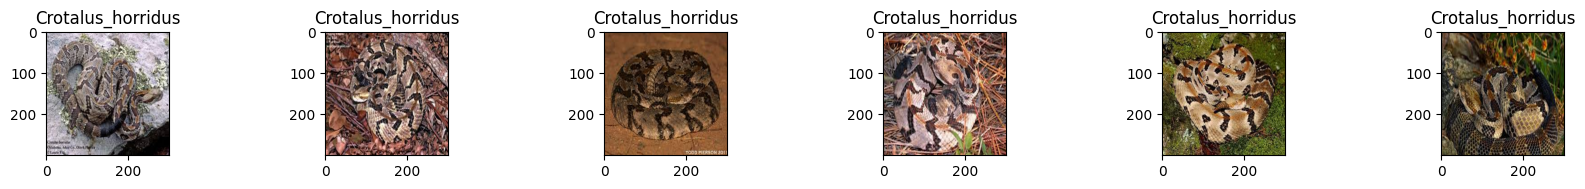

In [ ]:
src_path = '/content/drive/MyDrive/snake-dataset/training'
sub_class = os.listdir(src_path)

img_per_subplot = 6  # Number of images per subplot
subplots_per_row = 6  # Number of subplots per row
num_rows = len(sub_class)
num_subplots = img_per_subplot * num_rows

for i in range(0, num_subplots, 126):
    # Create a new figure for each set of subplots (up to 126 subplots per figure)
    fig = plt.figure(figsize=(21, 40))

    for j in range(i, min(i + 126, num_subplots)):
        label = j // img_per_subplot
        img_index = j % img_per_subplot

        path = os.path.join(src_path, sub_class[label])
        img = os.listdir(path)

        plt.subplot(21, subplots_per_row, img_index + 1)
        image = Image.open(os.path.join(path, img[img_index]))
        image = image.resize((300, 300))
        plt.imshow(image)
        plt.title(sub_class[label])

#### **Fit Pre-Trained Model with New Layers**
VGG16 model is taken from the Keras Applications and new layers are added.
Manually added FLATTEN > 2DENSE > DENSE-SOFTMAX

In [ ]:
model_train = VGG16(input_shape = (224,224,3) , weights = 'imagenet', include_top = False)

for layer in model_train.layers:
    layer.trainable = False

x = Reshape((7*7,512))(model_train.output)
x = Flatten()(x)
x = Dense(128)(x)
x = Dense(64)(x)
prediction = Dense(24, activation='softmax')(x)

# create a model object
mod3 = Model(inputs = model_train.input, outputs = prediction)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
mod3.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.01) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
train_history3 = train_model(mod3, train_generator, validation_generator, epochs = 70, name = 'vgg16')

#### **Save Model's Performance and History**

In [ ]:
# Evaluate performance
validation_evaluation = mod3.evaluate(validation_generator)
training_evaluation = mod3.evaluate(train_generator)

print('Evaluation on Validation Data:', validation_evaluation)
print('Evaluation on Training Data:', training_evaluation)

138/138 [==============================] - 54s 391ms/step - loss: 2.0485 - accuracy: 0.4426
Evaluation on Validation Data: [2.354538917541504, 0.38232162594795227]
Evaluation on Training Data: [2.0485353469848633, 0.44262295961380005]


In [ ]:
# Saving the model
tf.keras.models.save_model(mod3,"/content/drive/MyDrive/snake-dataset/model_v3.8.h5")

with open('/content/drive/MyDrive/snake-dataset/model_history_v3.8.pkl', 'rb') as file_pi:
    loaded_history = pickle.load(file_pi)

<ipython-input-9-3242e8bc6508>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(mod3,"/content/drive/MyDrive/snake-dataset/model_v3.8.h5")


#### **Analysis on Model**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory where your validation data is located
validation_data_dir = '/content/drive/MyDrive/snake-dataset/validation'

# Create an ImageDataGenerator for validation data
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Define the batch size and image size
batch_size = 32
image_size = (224, 224)

# Create a validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'  # Change this to your dataset's class_mode
)

Found 939 images belonging to 24 classes.


In [ ]:
# Loading the model
mod = tf.keras.models.load_model("/content/drive/MyDrive/snake-dataset/model_v3.8.h5")

# Loading the history
with open('/content/drive/MyDrive/snake-dataset/model_history_v3.8.pkl', "rb") as file_pi:
    history = pickle.load(file_pi)

# List all data in history
print(history.keys())

testing_folder = '/content/drive/MyDrive/snake-dataset/testing'
image_files = os.listdir(testing_folder)

def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

In [ ]:
from sklearn.metrics import accuracy_score

validation_predictions = mod.predict(validation_generator)

true_labels = validation_generator.classes  # True labels for the validation dataset
predicted_labels = np.argmax(validation_predictions, axis=1)  # Predicted labels

species_accuracy = {}  # Dictionary to store accuracy for each species
species_counts = {}   # Dictionary to store the number of images for each species

# Get the list of species from the training dataset directory
train_data_dir = '/content/drive/MyDrive/snake-dataset/training'
sub_class = os.listdir(train_data_dir)

for species_idx, species_name in enumerate(validation_generator.class_indices):
    species_mask = true_labels == species_idx
    accuracy = accuracy_score(
        true_labels[species_mask], predicted_labels[species_mask]
    )
    species_accuracy[species_name] = accuracy

# Count the number of images for each species in the training dataset
for species_name in sub_class:
    train_species_dir = os.path.join(train_data_dir, species_name)
    num_images = len(os.listdir(train_species_dir))
    species_counts[species_name] = num_images

# Sort the species by accuracy in ascending order
sorted_species_accuracy = dict(sorted(species_accuracy.items(), key=lambda item: item[1]))

# Print the accuracy and number of images for each species from least to greatest
for species_name, accuracy in sorted_species_accuracy.items():
    num_images = species_counts[species_name]
    print(f"Species: {species_name}, Accuracy: {accuracy}, Number of Images: {num_images}")

30/30 [==============================] - 194s 6s/step
Species: Crotalus_horridus, Accuracy: 0.0, Number of Images: 70
Species: Lampropeltis_gentilis, Accuracy: 0.0, Number of Images: 156
Species: Pantherophis_obsoleta, Accuracy: 0.0, Number of Images: 47
Species: Tantilla_nigriceps, Accuracy: 0.0, Number of Images: 50
Species: Heterodon_nasicus, Accuracy: 0.016666666666666666, Number of Images: 140
Species: Crotalus_viridia, Accuracy: 0.027777777777777776, Number of Images: 205
Species: Nerodia_sipedon, Accuracy: 0.030303030303030304, Number of Images: 156
Species: Storeria_occipitomaculata, Accuracy: 0.030303030303030304, Number of Images: 79
Species: Coluber_flagellum, Accuracy: 0.03076923076923077, Number of Images: 147
Species: Agkistrodon_contortrix, Accuracy: 0.03333333333333333, Number of Images: 140
Species: Carphophis_vermis, Accuracy: 0.038461538461538464, Number of Images: 44
Species: Storeria_dekayi, Accuracy: 0.038461538461538464, Number of Images: 41
Species: Lampropeltis

#### **Run Model on Test Dataset**

In [ ]:
species_info = {
    "Agkistrodon_contortrix": {
        "common_name": "Eastern Copperhead",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Arizona_elegans": {
        "common_name": "Glossy snake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Carphophis_vermis": {
        "common_name": "Western worm snake",
        "description_size": "Description & Size 1",
        "habitat": "Habitat 1",
        "diet": "Diet 1",
        "life_history": "Life History 1",
    },
    "Coluber_constrictor": {
        "common_name": "North American racer",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Coluber_flagellum": {
        "common_name": "Coachwhip",
        "description_size": "Description & Size 1",
        "habitat": "Habitat 1",
        "diet": "Diet 1",
        "life_history": "Life History 1",
    },
    "Crotalus_horridus": {
        "common_name": "Timber rattlesnake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Crotalus_viridia": {
        "common_name": "Prairie rattlesnake",
        "description_size": "Description & Size 1",
        "habitat": "Habitat 1",
        "diet": "Diet 1",
        "life_history": "Life History 1",
    },
    "Diadophis_punctatus": {
        "common_name": "Ring-necked snake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Heterodon_nasicus": {
        "common_name": "Plains hog-nosed snake",
        "description_size": "Description & Size 1",
        "habitat": "Habitat 1",
        "diet": "Diet 1",
        "life_history": "Life History 1",
    },
    "Lampropeltis_calligaster": {
        "common_name": "Prairie kingsnake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Lampropeltis_gentilis": {
        "common_name": "Western milksnake",
        "description_size": "Description & Size 1",
        "habitat": "Habitat 1",
        "diet": "Diet 1",
        "life_history": "Life History 1",
    },
    "Lampropeltis_holbrooki": {
        "common_name": "Speckled kingsnake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Nerodia_sipedon": {
        "common_name": "Common watersnake",
        "description_size": "Description & Size 1",
        "habitat": "Habitat 1",
        "diet": "Diet 1",
        "life_history": "Life History 1",
    },
    "Opheodrys_vernalis": {
        "common_name": "Smooth green snake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Pantherophis_emoryi": {
        "common_name": "Great plains ratsnake",
        "description_size": "Description & Size 1",
        "habitat": "Habitat 1",
        "diet": "Diet 1",
        "life_history": "Life History 1",
    },
    "Pantherophis_obsoleta": {
        "common_name": "Western black ratsnake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Pantherophis_ramspotti": {
        "common_name": "Western fox snake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Pituophis_catenifer": {
        "common_name": "Bullsnake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Regina_grahami": {
        "common_name": "Graham's crayfish snake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Storeria_dekayi": {
        "common_name": "Dekay's Brownsnake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Storeria_occipitomaculata": {
        "common_name": "Red-bellied snake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Tantilla_nigriceps": {
        "common_name": "Plains black-headed snake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Thamnophis_proximus": {
        "common_name": "Western ribbonsnake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    },
    "Tropidoclonion_lineatum": {
        "common_name": "Lined snake",
        "description_size": "Description & Size 2",
        "habitat": "Habitat 2",
        "diet": "Diet 2",
        "life_history": "Life History 2",
    }
}

In [ ]:
img_width, img_height = 224, 224
val_generator = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = val_generator.flow_from_directory(
    directory='/content/drive/MyDrive/snake-dataset/validation',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

# Get the list of class labels as a subscriptable list
class_labels = list(validation_generator.class_indices.keys())

# Make predictions for each image in the 'testing' folder
for image_file in image_files:
    image_path = os.path.join(testing_folder, image_file)
    image = preprocess_image(image_path)

    # Make predictions using the model
    predictions = mod.predict(image)

    # Get the predicted class and its confidence
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    confidence_percentage = np.max(predictions) * 100

    # Find the additional information associated with the predicted species
    if predicted_class in species_info:
        species_data = species_info[predicted_class]
    else:
        species_data = {
            "common_name": "N/A",
            "description_size": "N/A",
            "habitat": "N/A",
            "diet": "N/A",
            "life_history": "N/A",
        }

    # Print the prediction result and additional information
    print(f"Image: {image_file}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence_percentage:.2f}%")
    print(f"Common Name: {species_data['common_name']}")
    print(f"Description & Size: {species_data['description_size']}")
    print(f"Habitat: {species_data['habitat']}")
    print(f"Diet: {species_data['diet']}")
    print(f"Life History: {species_data['life_history']}")
    print("-" * 30)

Found 939 images belonging to 24 classes.
1/1 [==============================] - 8s 8s/step
Image: Great Plains Ratsnake1.jpeg
Predicted Class: Diadophis_punctatus
Confidence: 82.18%
Common Name: Ring-necked snake
Description & Size: Description & Size 2
Habitat: Habitat 2
Diet: Diet 2
Life History: Life History 2
------------------------------
1/1 [==============================] - 0s 30ms/step
Image: Great Plains Ratsnake2.jpeg
Predicted Class: Lampropeltis_gentilis
Confidence: 47.79%
Common Name: Western milksnake
Description & Size: Description & Size 1
Habitat: Habitat 1
Diet: Diet 1
Life History: Life History 1
------------------------------
1/1 [==============================] - 0s 35ms/step
Image: Great Plains Ratsnake3.jpeg
Predicted Class: Lampropeltis_gentilis
Confidence: 46.04%
Common Name: Western milksnake
Description & Size: Description & Size 1
Habitat: Habitat 1
Diet: Diet 1
Life History: Life History 1
------------------------------
1/1 [==============================